### Full Preprocessing Phase
[source](https://www.kaggle.com/asura93/full-preprocessing-tutorial)

Contents

1. Load data
    - 1.1 Function to load data


In [5]:
# %matplotlib inline
%matplotlib widget

import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import exposure, img_as_float
from natsort import natsorted
import cv2 as cv


from skimage import measure, morphology


Helper function for MRI slices
- Read mri (.dcm) files
- 2D visualization of MRI Scans

In [21]:
IMAGES_PATH = os.path.join('..', 'dataset', 'images')
MASKS_PATH = os.path.join('..', 'dataset', 'masks')

image_paths = natsorted(os.listdir(IMAGES_PATH))
mask_paths = natsorted(os.listdir(MASKS_PATH))

# Load the scans in given folder path
def load_scan(path, debug=True):
    if debug:
        slices = [dicom.dcmread(path + os.sep + s).pixel_array for s in natsorted(os.listdir(path)[49:70])]
        # slices = [x/255.0 for x in slices]
        # slices = [x.astype(np.float32) for x in slices]
    else:
        slices = [dicom.dcmread(path + os.sep + s) for s in natsorted(os.listdir(path))]
    
    # slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    # try:
    #     slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    # except:
    #     slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    # for s in slices:
    #     s.SliceThickness = slice_thickness

    return slices

def load_mask(path, debug=True):
    if debug:
        masks = [plt.imread(path + os.sep + s)[:,:,0] for s in natsorted(os.listdir(path)[49:70])]
        # masks = [x/255.0 for x in masks]
        # masks = [x.astype(np.float32) for x in masks]
    else:
        masks = [plt.imread(path + os.sep + s)[:,:,0] for s in natsorted(os.listdir(path))]
    return masks 
##########################################################################
# Multi-slice view code extracted and adapted from: 
# https://www.datacamp.com/community/tutorials/matplotlib-3d-volumetric-data

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def single_slice_viewer(image, mask):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    ax.imshow(mask, cmap='jet', alpha=0.2)
    # ax.set_title(image_path)
    plt.show()
                
def multi_slice_viewer(volume, mask, no_axis=False):
    remove_keymap_conflicts({'j', 'k'})
    fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10,10))

    ax1.volume = volume
    ax1.index = 0
    ax1.imshow(volume[ax1.index],cmap="gray")
    ax1.set_title(str(image_paths[ax1.index]))

    ax2.volume = mask
    ax2.index = 0
    ax2.imshow(mask[ax2.index],cmap="gray")
    ax2.set_title(str(mask_paths[ax2.index]))

    ax3.index = 0
    # ax3.volume = [cv.addWeighted(np.asarray(i, np.float64), 0.001, np.asarray(m, np.float64), 0.9, 0) for i, m in zip(volume, mask)]
    ax3.volume = [(i * 0.009) + (m * 0.9) for i, m in zip(volume, mask)]
    # ax3.volume = mask[ax3.index]
    ax3.imshow(ax3.volume[ax3.index], cmap='jet')
    # ax3.imshow(mask[ax3.index], cmap='jet', alpha=0.2)
    ax3.set_title('Combined')

    fig.canvas.mpl_connect('key_press_event', process_key)
    
            
def process_key(event):
    # Process key_press events
    fig = event.canvas.figure
    ax1 = fig.axes[0]
    ax2 = fig.axes[1]
    ax3 = fig.axes[2]

    if event.key == 'j':
        previous_slice(ax1, 'image')
        previous_slice(ax2, 'mask')
        previous_slice(ax3, 'combined')
    elif event.key == 'k':
        next_slice(ax1, 'image') 
        next_slice(ax2, 'mask')
        next_slice(ax3, 'combined') 
    elif event.key == 'd':
        remove_image(ax1,ax2,ax3)
        previous_slice(ax1, 'image') 
        previous_slice(ax2, 'mask')
        previous_slice(ax3, 'combined') 
        
    fig.canvas.draw()

def remove_image(ax1, ax2, ax3):    
    global image_paths, mask_paths
    try:
        os.remove(os.path.join(IMAGES_PATH, image_paths[ax1.index]))
    except:
        print("Error while deleting file ", image_paths[ax1.index])
    try:
        os.remove(os.path.join(MASKS_PATH, mask_paths[ax2.index]))
    except:
        print("Error while deleting file ", mask_paths[ax2.index])
    
    image_paths = natsorted(os.listdir(IMAGES_PATH))
    mask_paths = natsorted(os.listdir(MASKS_PATH))
    del ax3.volume[ax3.index]

def previous_slice(ax, type):
    # Go to the previous slice
    volume = ax.volume
    ax.index = (ax.index-1) % len(volume)
    ax.images[0].set_array(volume[ax.index])
    if type == 'image': ax.set_title(str(image_paths[ax.index]))
    elif type == 'mask': ax.set_title(str(mask_paths[ax.index]))
    elif type == 'combined': ax.set_title('Combined')

def next_slice(ax, type):
    # Go to the next slice
    volume = ax.volume
    ax.index = (ax.index+1) % len(volume)
    ax.images[0].set_array(volume[ax.index])
    if type == 'image': ax.set_title(str(image_paths[ax.index]))
    elif type == 'mask': ax.set_title(str(mask_paths[ax.index]))
    elif type == 'combined': ax.set_title('Combined')

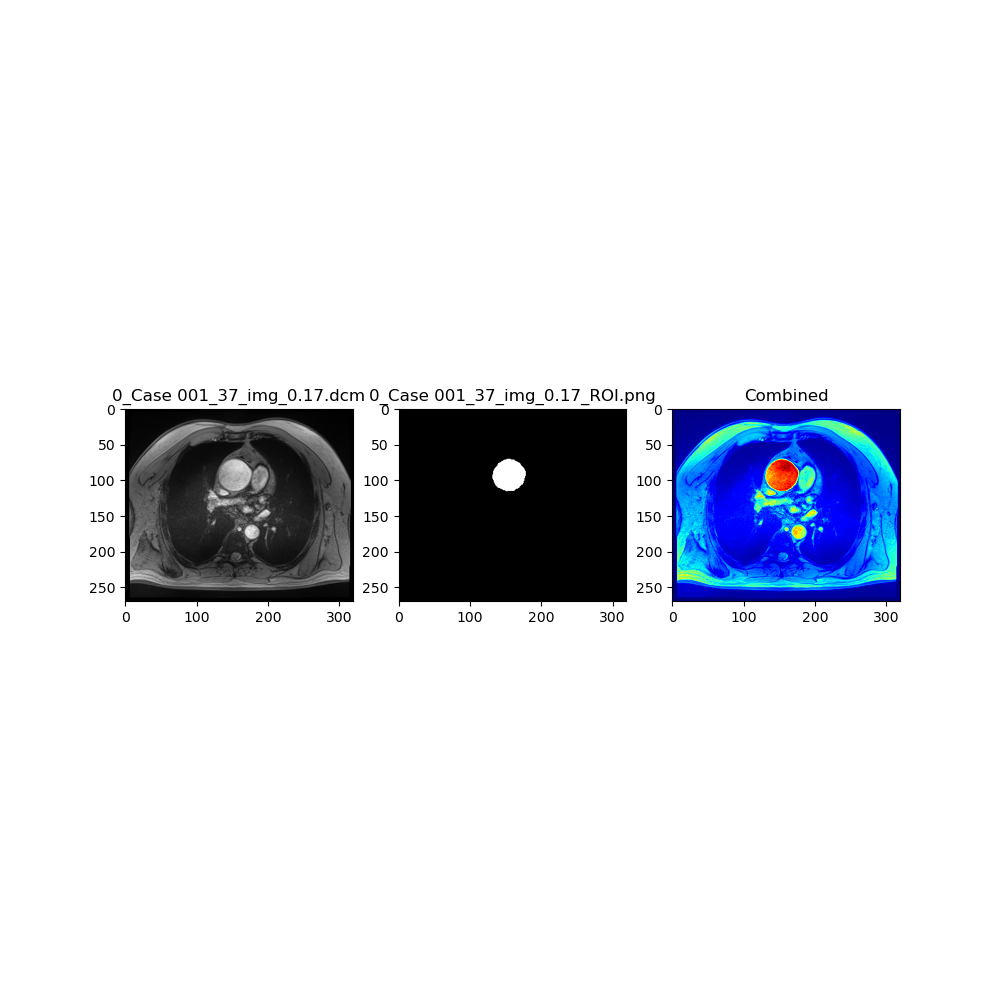

In [22]:
images = [image for image in load_scan(IMAGES_PATH)]
masks = [mask for mask in load_mask(MASKS_PATH)]


multi_slice_viewer(images, masks)

# for image, mask in zip(images, masks):
#     single_slice_viewer(image, mask)